In [1]:
%%capture
!pip install --upgrade tensorflow keras

In [2]:
from tensorflow.keras import layers
from keras.models import Model
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.losses import MeanSquaredError
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import pandas as pd
# from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model

import pickle as pkl
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

2024-03-05 03:14:58.777816: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 03:14:58.777887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 03:14:58.779678: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 03:14:58.789212: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-05 03:14:59.660526: W tensorflow/compiler/tf2

In [3]:
# from keras.utils.vis_utils import plot_model

In [4]:
train_data = pd.read_csv('./train/train.csv')

In [5]:
train_data.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


In [6]:
train_data.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

In [7]:
train_data.AdoptionSpeed.value_counts()

AdoptionSpeed
4    4197
2    4037
3    3259
1    3090
0     410
Name: count, dtype: int64

In [8]:
train_data.drop(['Name', 'RescuerID'], axis = 1, inplace = True)

In [9]:
train_data['AdoptionSpeed'][train_data['AdoptionSpeed']<=2] = 1

/tmp/ipykernel_128/2688933274.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['AdoptionSpeed'][train_data['AdoptionSpeed']<=2] = 1


In [10]:
train_data['AdoptionSpeed'][train_data['AdoptionSpeed']>2] = 0

/tmp/ipykernel_128/2943741512.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['AdoptionSpeed'][train_data['AdoptionSpeed']>2] = 0


In [11]:
train_data.AdoptionSpeed.value_counts()

AdoptionSpeed
1    7537
0    7456
Name: count, dtype: int64

In [12]:
train_data

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,...,Sterilized,Health,Quantity,Fee,State,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,3,299,0,1,1,7,0,1,1,...,2,1,1,100,41326,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,1
1,2,1,265,0,1,1,2,0,2,2,...,3,1,1,0,41401,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,1
2,1,1,307,0,1,2,7,0,2,2,...,2,1,1,0,41326,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,0
3,1,4,307,0,2,1,2,0,2,1,...,2,1,1,150,41401,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,1
4,1,1,307,0,1,1,0,0,2,1,...,2,1,1,0,41326,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,2,266,0,3,1,0,0,2,2,...,2,1,4,0,41326,0,I have 4 kittens that need to be adopt urgentl...,dc0935a84,3.0,1
14989,2,60,265,264,3,1,4,7,2,2,...,1,1,2,0,41326,0,Serato(female cat- 3 color) is 4 years old and...,a01ab5b30,3.0,0
14990,2,2,265,266,3,5,6,7,3,2,...,3,1,5,30,41326,0,"Mix breed, good temperament kittens. Love huma...",d981b6395,5.0,0
14991,2,9,266,0,2,4,7,0,1,1,...,1,1,1,0,41336,0,she is very shy..adventures and independent..s...,e4da1c9e4,3.0,0


In [13]:
tr_data = train_data.copy(deep=True)

In [14]:
# tr_data.count()

In [15]:
tr_data.dropna(inplace = True)
tr_data.reset_index(inplace = True)
# tr_data.count()

In [16]:
train_text = tr_data[['Description','AdoptionSpeed']]

In [17]:
train_text.head()

,Description,AdoptionSpeed
0,Nibble is a 3+ month old ball of cuteness. He ...,1
1,I just found it alone yesterday near my apartm...,1
2,Their pregnant mother was dumped by her irresp...,0
3,"Good guard dog, very alert, active, obedience ...",1
4,This handsome yet cute boy is up for adoption....,1


In [18]:
import os
img_files = os.listdir('./train_images/')

In [19]:
files = [img for img in img_files if img.endswith('-1.jpg')]

In [20]:
files[:3]

['2ae2246a7-1.jpg', '3e2cc2690-1.jpg', 'a996f1370-1.jpg']

In [21]:
len(files)

14652

In [22]:
img_names = set(imgname[:-6] for imgname in files)

In [23]:
# tr_data.head(

In [24]:
img_omit = set(tr_data['PetID']) - img_names

In [25]:
tr_data = tr_data[~tr_data.PetID.isin(img_omit)]

In [26]:
len(tr_data)

14640

In [27]:
# set(files)

In [28]:
tr_text = tr_data[['Description','AdoptionSpeed']]

In [29]:
tr_img = tr_data[['PetID','AdoptionSpeed']]

In [30]:
remove = img_names-set(tr_data['PetID']) 

In [31]:
def generate_image_name(pet_id):
    return f"{pet_id}-1.jpg"

# Create a new column 'ImageName' by applying the function to the 'PetID' column
tr_img['ImageName'] = tr_img['PetID'].apply(generate_image_name)

/tmp/ipykernel_128/567395424.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr_img['ImageName'] = tr_img['PetID'].apply(generate_image_name)


In [32]:
# os.listdir('cephfs/ceph/DSC261/project/train_images')[:10]

In [33]:
# for remove_ in remove:
#     img_names.remove(remove_)
# def img_data(x):
    

In [34]:
tr_tab = tr_data.drop(['Description', 'PetID', 'index' ,'Breed2'], axis = 1)

In [35]:
tr_tab.Breed1.value_counts()

Breed1
307    5818
266    3555
265    1236
299     332
264     292
       ... 
214       1
125       1
123       1
23        1
81        1
Name: count, Length: 175, dtype: int64

In [36]:
breed_df = pd.read_csv('./PetFinder-BreedLabels.csv')
breed_df.drop(['Type'], axis = 1, inplace = True)

In [37]:
merged_data = tr_tab.merge(breed_df, left_on = 'Breed1', right_on = 'BreedID', how = 'left').drop(
    ['Breed1', 'BreedID'], axis = 1)

In [38]:
# For 'BreedName_x'
breed_counts_x = merged_data['BreedName'].value_counts()
replace_breeds_x = breed_counts_x[breed_counts_x <= 100].index
merged_data['BreedName'] = merged_data['BreedName'].apply(lambda x: 'Others' if x in replace_breeds_x else x)


# For 'BreedName_y'
# breed_counts_y = merged_data['BreedName_y'].value_counts()
# replace_breeds_y = breed_counts_y[breed_counts_y <= 100].index

# For 'BreedName_x'

# For 'BreedName_y'
# merged_data['BreedName_y'] = merged_data['BreedName_y'].apply(lambda x: 'Others' if x in replace_breeds_y else x)



In [39]:
merged_data

,Type,Age,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed,BreedName
0,2,3,1,1,7,0,1,1,2,2,2,1,1,100,41326,0,1.0,1,Tabby
1,2,1,1,1,2,0,2,2,3,3,3,1,1,0,41401,0,2.0,1,Domestic Medium Hair
2,1,1,1,2,7,0,2,2,1,1,2,1,1,0,41326,0,7.0,0,Mixed Breed
3,1,4,2,1,2,0,2,1,1,1,2,1,1,150,41401,0,8.0,1,Mixed Breed
4,1,1,1,1,0,0,2,1,2,2,2,1,1,0,41326,0,3.0,1,Mixed Breed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,2,2,3,1,0,0,2,2,2,2,2,1,4,0,41326,0,3.0,1,Domestic Short Hair
14636,2,60,3,1,4,7,2,2,1,1,1,1,2,0,41326,0,3.0,0,Domestic Medium Hair
14637,2,2,3,5,6,7,3,2,2,1,3,1,5,30,41326,0,5.0,0,Domestic Medium Hair
14638,2,9,2,4,7,0,1,1,1,1,1,1,1,0,41336,0,3.0,0,Domestic Short Hair


In [40]:
type_mapping_type = {1: 'Dog', 2: 'Cat'}
merged_data['Type'] = merged_data['Type'].map(type_mapping_type)
merged_data

,Type,Age,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed,BreedName
0,Cat,3,1,1,7,0,1,1,2,2,2,1,1,100,41326,0,1.0,1,Tabby
1,Cat,1,1,1,2,0,2,2,3,3,3,1,1,0,41401,0,2.0,1,Domestic Medium Hair
2,Dog,1,1,2,7,0,2,2,1,1,2,1,1,0,41326,0,7.0,0,Mixed Breed
3,Dog,4,2,1,2,0,2,1,1,1,2,1,1,150,41401,0,8.0,1,Mixed Breed
4,Dog,1,1,1,0,0,2,1,2,2,2,1,1,0,41326,0,3.0,1,Mixed Breed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,Cat,2,3,1,0,0,2,2,2,2,2,1,4,0,41326,0,3.0,1,Domestic Short Hair
14636,Cat,60,3,1,4,7,2,2,1,1,1,1,2,0,41326,0,3.0,0,Domestic Medium Hair
14637,Cat,2,3,5,6,7,3,2,2,1,3,1,5,30,41326,0,5.0,0,Domestic Medium Hair
14638,Cat,9,2,4,7,0,1,1,1,1,1,1,1,0,41336,0,3.0,0,Domestic Short Hair


In [41]:
type_mapping_gender = {1: 'Male', 2: 'Female', 3: 'Mixed'}
merged_data['Gender'] = merged_data['Gender'].map(type_mapping_gender)
merged_data

,Type,Age,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed,BreedName
0,Cat,3,Male,1,7,0,1,1,2,2,2,1,1,100,41326,0,1.0,1,Tabby
1,Cat,1,Male,1,2,0,2,2,3,3,3,1,1,0,41401,0,2.0,1,Domestic Medium Hair
2,Dog,1,Male,2,7,0,2,2,1,1,2,1,1,0,41326,0,7.0,0,Mixed Breed
3,Dog,4,Female,1,2,0,2,1,1,1,2,1,1,150,41401,0,8.0,1,Mixed Breed
4,Dog,1,Male,1,0,0,2,1,2,2,2,1,1,0,41326,0,3.0,1,Mixed Breed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,Cat,2,Mixed,1,0,0,2,2,2,2,2,1,4,0,41326,0,3.0,1,Domestic Short Hair
14636,Cat,60,Mixed,1,4,7,2,2,1,1,1,1,2,0,41326,0,3.0,0,Domestic Medium Hair
14637,Cat,2,Mixed,5,6,7,3,2,2,1,3,1,5,30,41326,0,5.0,0,Domestic Medium Hair
14638,Cat,9,Female,4,7,0,1,1,1,1,1,1,1,0,41336,0,3.0,0,Domestic Short Hair


In [42]:
type_mapping_color = {1: 'Black', 2: 'Brown', 3: 'Golden', 4: 'Yellow', 5: 'Cream', 6: 'Gray', 7: 'White', 0: 'NA' }
merged_data['Color1'] = merged_data['Color1'].map(type_mapping_color)
merged_data['Color2'] = merged_data['Color2'].map(type_mapping_color)
merged_data['Color3'] = merged_data['Color3'].map(type_mapping_color)

merged_data

,Type,Age,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed,BreedName
0,Cat,3,Male,Black,White,NA,1,1,2,2,2,1,1,100,41326,0,1.0,1,Tabby
1,Cat,1,Male,Black,Brown,NA,2,2,3,3,3,1,1,0,41401,0,2.0,1,Domestic Medium Hair
2,Dog,1,Male,Brown,White,NA,2,2,1,1,2,1,1,0,41326,0,7.0,0,Mixed Breed
3,Dog,4,Female,Black,Brown,NA,2,1,1,1,2,1,1,150,41401,0,8.0,1,Mixed Breed
4,Dog,1,Male,Black,NA,NA,2,1,2,2,2,1,1,0,41326,0,3.0,1,Mixed Breed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,Cat,2,Mixed,Black,NA,NA,2,2,2,2,2,1,4,0,41326,0,3.0,1,Domestic Short Hair
14636,Cat,60,Mixed,Black,Yellow,White,2,2,1,1,1,1,2,0,41326,0,3.0,0,Domestic Medium Hair
14637,Cat,2,Mixed,Cream,Gray,White,3,2,2,1,3,1,5,30,41326,0,5.0,0,Domestic Medium Hair
14638,Cat,9,Female,Yellow,White,NA,1,1,1,1,1,1,1,0,41336,0,3.0,0,Domestic Short Hair


In [43]:
type_mapping_vaccination = {1: 'Yes', 2: 'No', 3: 'NotSure'}
merged_data['Vaccinated'] = merged_data['Vaccinated'].map(type_mapping_vaccination)

type_mapping_Dewormed = {1: 'Yes', 2: 'No', 3: 'NotSure'}
merged_data['Dewormed'] = merged_data['Dewormed'].map(type_mapping_Dewormed)

type_mapping_Sterilized = {1: 'Yes', 2: 'No', 3: 'NotSure'}
merged_data['Sterilized'] = merged_data['Sterilized'].map(type_mapping_Sterilized)

merged_data

,Type,Age,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed,BreedName
0,Cat,3,Male,Black,White,NA,1,1,No,No,No,1,1,100,41326,0,1.0,1,Tabby
1,Cat,1,Male,Black,Brown,NA,2,2,NotSure,NotSure,NotSure,1,1,0,41401,0,2.0,1,Domestic Medium Hair
2,Dog,1,Male,Brown,White,NA,2,2,Yes,Yes,No,1,1,0,41326,0,7.0,0,Mixed Breed
3,Dog,4,Female,Black,Brown,NA,2,1,Yes,Yes,No,1,1,150,41401,0,8.0,1,Mixed Breed
4,Dog,1,Male,Black,NA,NA,2,1,No,No,No,1,1,0,41326,0,3.0,1,Mixed Breed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,Cat,2,Mixed,Black,NA,NA,2,2,No,No,No,1,4,0,41326,0,3.0,1,Domestic Short Hair
14636,Cat,60,Mixed,Black,Yellow,White,2,2,Yes,Yes,Yes,1,2,0,41326,0,3.0,0,Domestic Medium Hair
14637,Cat,2,Mixed,Cream,Gray,White,3,2,No,Yes,NotSure,1,5,30,41326,0,5.0,0,Domestic Medium Hair
14638,Cat,9,Female,Yellow,White,NA,1,1,Yes,Yes,Yes,1,1,0,41336,0,3.0,0,Domestic Short Hair


In [44]:
state_df = pd.read_csv('./state_labels.csv')

In [45]:
merged_data

,Type,Age,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed,BreedName
0,Cat,3,Male,Black,White,NA,1,1,No,No,No,1,1,100,41326,0,1.0,1,Tabby
1,Cat,1,Male,Black,Brown,NA,2,2,NotSure,NotSure,NotSure,1,1,0,41401,0,2.0,1,Domestic Medium Hair
2,Dog,1,Male,Brown,White,NA,2,2,Yes,Yes,No,1,1,0,41326,0,7.0,0,Mixed Breed
3,Dog,4,Female,Black,Brown,NA,2,1,Yes,Yes,No,1,1,150,41401,0,8.0,1,Mixed Breed
4,Dog,1,Male,Black,NA,NA,2,1,No,No,No,1,1,0,41326,0,3.0,1,Mixed Breed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,Cat,2,Mixed,Black,NA,NA,2,2,No,No,No,1,4,0,41326,0,3.0,1,Domestic Short Hair
14636,Cat,60,Mixed,Black,Yellow,White,2,2,Yes,Yes,Yes,1,2,0,41326,0,3.0,0,Domestic Medium Hair
14637,Cat,2,Mixed,Cream,Gray,White,3,2,No,Yes,NotSure,1,5,30,41326,0,5.0,0,Domestic Medium Hair
14638,Cat,9,Female,Yellow,White,NA,1,1,Yes,Yes,Yes,1,1,0,41336,0,3.0,0,Domestic Short Hair


In [46]:
merged_data = merged_data.merge(state_df, how = 'left', left_on = 'State', 
                                right_on = 'StateID').drop(['StateID', 'State'], axis = 1)

In [47]:
states = merged_data.StateName.value_counts()
statelst = states[states<150].index.tolist()
# .index.tolist()

In [48]:
merged_data.StateName.value_counts()

StateName
Selangor           8516
Kuala Lumpur       3745
Pulau Pinang        833
Johor               485
Perak               411
Negeri Sembilan     249
Melaka              134
Kedah               107
Pahang               83
Terengganu           25
Sabah                22
Kelantan             14
Sarawak              13
Labuan                3
Name: count, dtype: int64

In [49]:
merged_data['BreedName'] = merged_data['BreedName'].apply(lambda x: 'Others' if x in replace_breeds_x else x)


In [50]:
merged_data['StateName'] = merged_data['StateName'].apply(lambda x: 'Others' if x in statelst else x)
merged_data

,Type,Age,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,VideoAmt,PhotoAmt,AdoptionSpeed,BreedName,StateName
0,Cat,3,Male,Black,White,NA,1,1,No,No,No,1,1,100,0,1.0,1,Tabby,Selangor
1,Cat,1,Male,Black,Brown,NA,2,2,NotSure,NotSure,NotSure,1,1,0,0,2.0,1,Domestic Medium Hair,Kuala Lumpur
2,Dog,1,Male,Brown,White,NA,2,2,Yes,Yes,No,1,1,0,0,7.0,0,Mixed Breed,Selangor
3,Dog,4,Female,Black,Brown,NA,2,1,Yes,Yes,No,1,1,150,0,8.0,1,Mixed Breed,Kuala Lumpur
4,Dog,1,Male,Black,NA,NA,2,1,No,No,No,1,1,0,0,3.0,1,Mixed Breed,Selangor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,Cat,2,Mixed,Black,NA,NA,2,2,No,No,No,1,4,0,0,3.0,1,Domestic Short Hair,Selangor
14636,Cat,60,Mixed,Black,Yellow,White,2,2,Yes,Yes,Yes,1,2,0,0,3.0,0,Domestic Medium Hair,Selangor
14637,Cat,2,Mixed,Cream,Gray,White,3,2,No,Yes,NotSure,1,5,30,0,5.0,0,Domestic Medium Hair,Selangor
14638,Cat,9,Female,Yellow,White,NA,1,1,Yes,Yes,Yes,1,1,0,0,3.0,0,Domestic Short Hair,Johor


In [51]:
# Assuming merged_data already has 'Color1', 'Color2', and 'Color3' columns correctly set up
# Create dummy variables for specified columns excluding the color columns initially
data_dummies = pd.get_dummies(merged_data[['Type', 'Gender', 'Vaccinated', 'Dewormed', 'Sterilized', 'BreedName', 'StateName']])

# Handle color columns by creating dummies and then scaling as needed
for color_col in ['Color1', 'Color2', 'Color3']:
    color_dummies = pd.get_dummies(merged_data[color_col], prefix='Color')
    # Adjust the multiplication factor based on the color column's importance
    if color_col == 'Color1':
        factor = 3
    elif color_col == 'Color2': 
        factor = 2
    else: factor = 1
    data_dummies = data_dummies.add(color_dummies.multiply(factor), fill_value=0)

# Now data_dummies contains all the original dummies plus aggregated and scaled color dummies


In [52]:
data_dummies['Color_Gray'].value_counts()

Color_Gray
0.0    12576
2.0     1032
3.0      663
1.0      369
Name: count, dtype: int64

In [53]:
data_dummies[['Color_Black', 'Color_Brown', 'Color_Cream', 'Color_Golden','Color_Gray', 'Color_White', 'Color_Yellow']] *= 3

In [54]:
final_tab_data = pd.concat([merged_data, data_dummies], axis = 1)

In [55]:
final_tab_data.head()

,Type,Age,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,...,StateName_Pulau Pinang,StateName_Selangor,Sterilized_No,Sterilized_NotSure,Sterilized_Yes,Type_Cat,Type_Dog,Vaccinated_No,Vaccinated_NotSure,Vaccinated_Yes
0,Cat,3,Male,Black,White,NA,1,1,No,No,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,Cat,1,Male,Black,Brown,NA,2,2,NotSure,NotSure,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,Dog,1,Male,Brown,White,NA,2,2,Yes,Yes,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,Dog,4,Female,Black,Brown,NA,2,1,Yes,Yes,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,Dog,1,Male,Black,NA,NA,2,1,No,No,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [56]:
final_tab_data.columns

Index(['Type', 'Age', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize',
       'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health',
       'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'AdoptionSpeed', 'BreedName',
       'StateName', 'BreedName_Calico', 'BreedName_Domestic Long Hair',
       'BreedName_Domestic Medium Hair', 'BreedName_Domestic Short Hair',
       'BreedName_Golden Retriever', 'BreedName_Labrador Retriever',
       'BreedName_Mixed Breed', 'BreedName_Others', 'BreedName_Persian',
       'BreedName_Poodle', 'BreedName_Shih Tzu', 'BreedName_Siamese',
       'BreedName_Tabby', 'BreedName_Terrier', 'Color_Black', 'Color_Brown',
       'Color_Cream', 'Color_Golden', 'Color_Gray', 'Color_NA', 'Color_White',
       'Color_Yellow', 'Dewormed_No', 'Dewormed_NotSure', 'Dewormed_Yes',
       'Gender_Female', 'Gender_Male', 'Gender_Mixed', 'StateName_Johor',
       'StateName_Kuala Lumpur', 'StateName_Negeri Sembilan',
       'StateName_Others', 'StateName_Perak', 'S

In [57]:
final_tab_data.drop(['Type', 'Gender', 'Vaccinated', 'Dewormed', 'Sterilized', 
                      'BreedName', 'StateName', 'Color1', 'Color2', 'Color3'], axis =1, inplace = True)

In [58]:
final_tab_data.drop('Color_NA', axis = 1 , inplace = True)
tab_data_y = final_tab_data['AdoptionSpeed']
tab_data_X = final_tab_data.drop('AdoptionSpeed', axis = 1)

In [59]:
tab_data_X

,Age,MaturitySize,FurLength,Health,Quantity,Fee,VideoAmt,PhotoAmt,BreedName_Calico,BreedName_Domestic Long Hair,...,StateName_Pulau Pinang,StateName_Selangor,Sterilized_No,Sterilized_NotSure,Sterilized_Yes,Type_Cat,Type_Dog,Vaccinated_No,Vaccinated_NotSure,Vaccinated_Yes
0,3,1,1,1,1,100,0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1,2,2,1,1,0,0,2.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1,2,2,1,1,0,0,7.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,4,2,1,1,1,150,0,8.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1,2,1,1,1,0,0,3.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,2,2,2,1,4,0,0,3.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
14636,60,2,2,1,2,0,0,3.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
14637,2,3,2,1,5,30,0,5.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
14638,9,1,1,1,1,0,0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [60]:
from sklearn.preprocessing import Normalizer


In [61]:
normalscaler = Normalizer()
tab_data_X = normalscaler.fit_transform(tab_data_X)

In [62]:
tab_data_X

array([[0.02979512, 0.00993171, 0.00993171, ..., 0.00993171, 0.        ,
        0.        ],
       [0.08481889, 0.16963779, 0.16963779, ..., 0.        , 0.08481889,
        0.        ],
       [0.07372098, 0.14744196, 0.14744196, ..., 0.        , 0.        ,
        0.07372098],
       ...,
       [0.06027488, 0.09041232, 0.06027488, ..., 0.03013744, 0.        ,
        0.        ],
       [0.60955692, 0.06772855, 0.06772855, ..., 0.        , 0.        ,
        0.06772855],
       [0.10153462, 0.20306923, 0.10153462, ..., 0.10153462, 0.        ,
        0.        ]])

In [63]:
final_tab_data

,Age,MaturitySize,FurLength,Health,Quantity,Fee,VideoAmt,PhotoAmt,AdoptionSpeed,BreedName_Calico,...,StateName_Pulau Pinang,StateName_Selangor,Sterilized_No,Sterilized_NotSure,Sterilized_Yes,Type_Cat,Type_Dog,Vaccinated_No,Vaccinated_NotSure,Vaccinated_Yes
0,3,1,1,1,1,100,0,1.0,1,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1,2,2,1,1,0,0,2.0,1,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1,2,2,1,1,0,0,7.0,0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,4,2,1,1,1,150,0,8.0,1,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1,2,1,1,1,0,0,3.0,1,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,2,2,2,1,4,0,0,3.0,1,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
14636,60,2,2,1,2,0,0,3.0,0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
14637,2,3,2,1,5,30,0,5.0,0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
14638,9,1,1,1,1,0,0,3.0,0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [64]:
from sklearn.model_selection import train_test_split

X_train_structured_std, X_test_structured_std, y_train_std, y_test_std = train_test_split(
    final_tab_data.drop('AdoptionSpeed', axis = 1), tab_data_y, test_size = 0.25, random_state = 42)


In [64]:
X_test_structured_std

,Age,MaturitySize,FurLength,Health,Quantity,Fee,VideoAmt,PhotoAmt,BreedName_Calico,BreedName_Domestic Long Hair,...,StateName_Pulau Pinang,StateName_Selangor,Sterilized_No,Sterilized_NotSure,Sterilized_Yes,Type_Cat,Type_Dog,Vaccinated_No,Vaccinated_NotSure,Vaccinated_Yes
4794,2,2,1,1,1,50,0,4.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
10480,3,2,2,1,1,100,0,3.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
8067,4,2,2,1,1,0,0,7.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8880,1,1,1,1,1,0,0,2.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
8292,1,2,2,1,2,0,0,4.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4664,6,1,1,1,1,0,0,3.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
9826,36,3,1,1,1,100,0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
11528,24,3,2,1,1,0,0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
9787,36,3,1,1,1,0,0,2.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
# %%capture
# pip install --upgrade tensorflow keras

In [ ]:

# X_train_structured_std = tab_data_X
# # X_test_structured_std = pd.read_csv('/data/X_test_structured.csv', sep = ';')

# y_train_std = tab_data_y.copy(deep = True)
# y_test_std = pd.read_csv('/data/y_test_std.csv', sep = ';')


# file = open("/data/model/y_numerical_scaler.pkl",'rb')
# y_numerical_scaler = pkl.load(file)
# file.close()

##### MODEL ARCHITECTURE
structured_input = layers.Input(shape=(X_train_structured_std.shape[1],)
                               , name='structured_features_input'
                              )

x = layers.Dense(X_train_structured_std.shape[1], 
                 activation='relu', 
                 kernel_initializer='he_normal')(structured_input) #80

dense_hidden = Dense(25, activation='relu', name='dense_hidden')(x)
last_layer = Dense(1, activation='sigmoid')(dense_hidden)
    

# declare the final model inputs and outputs
final_model = Model(inputs=structured_input, outputs=last_layer)

# print a summary of the model
print(final_model.summary())

# set up learning rate decay schedule
initial_learning_rate = 0.15
lr_schedule = ExponentialDecay(
    initial_learning_rate,
        decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

stop = EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, mode='min', verbose=1)
best = ModelCheckpoint(filepath='./trModel.hdf5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# compile the model



final_model.compile(optimizer=Adam(learning_rate=lr_schedule, epsilon=1), 
                    loss="binary_crossentropy", 
                    metrics=['accuracy'])

plot_model(final_model, show_shapes=True, to_file='model1_structured.png')


results = final_model.fit(
            X_train_structured_std, y_train_std,
            epochs=500,
            callbacks=[stop, best],
            validation_data=(X_test_structured_std, y_test_std)
            # validation_data=([X_test_structured_std, y_test_std])
            )

final_model.save('./final_trModel.hdf5')

In [ ]:
pip install shap


In [ ]:
import numpy as np
x = X_train_structured_std.iloc[np.random.choice(X_train_structured_std.shape[0], 1000, replace=False)]

In [91]:
x.to_numpy()

array([[ 3.,  1.,  1., ...,  0.,  0.,  1.],
       [ 3.,  2.,  1., ...,  1.,  0.,  0.],
       [18.,  2.,  2., ...,  0.,  0.,  1.],
       ...,
       [ 6.,  1.,  1., ...,  1.,  0.,  0.],
       [ 1.,  2.,  2., ...,  1.,  0.,  0.],
       [ 2.,  1.,  1., ...,  1.,  0.,  0.]])

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


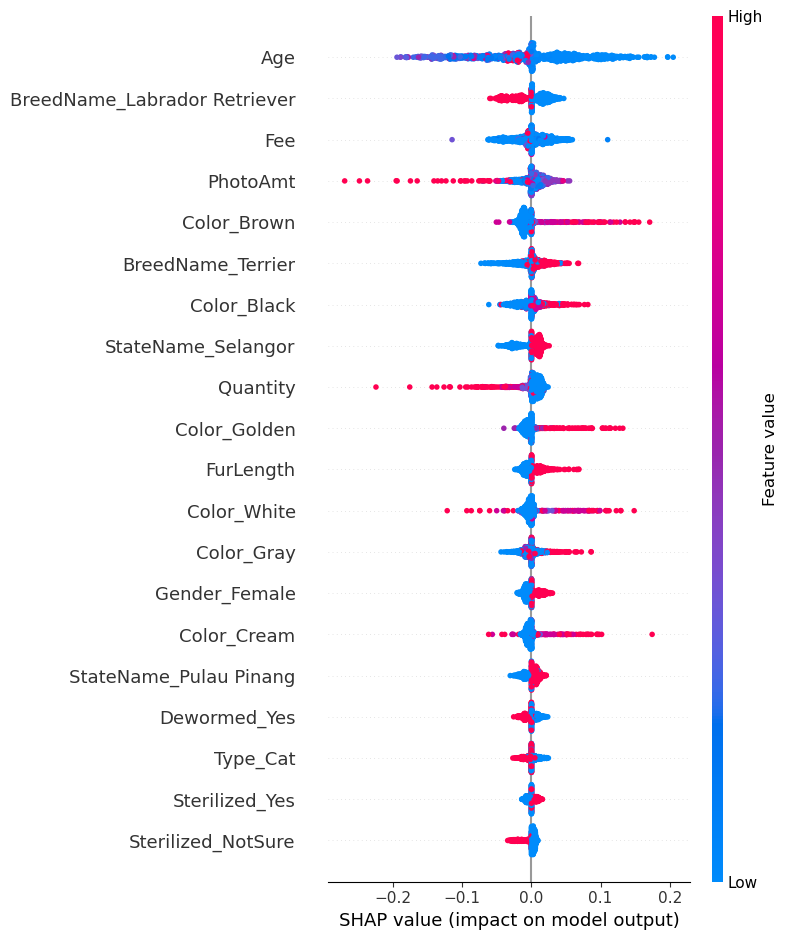

In [102]:
import shap 

background = X_train_structured_std.iloc[np.random.choice(X_train_structured_std.shape[0], 1000, replace=False)]
explainer = shap.DeepExplainer(final_model, background.to_numpy())

shap_values = explainer.shap_values(X_train_structured_std[:1000].to_numpy())
shap.summary_plot(shap_values[0], X_train_structured_std[:1000], feature_names=final_tab_data.columns.tolist())  # Replace with your actual feature names


In [391]:
import shap

# Assuming 'explainer' is already created and 'expected_value_numpy' is defined,
# and 'final_tab_data.columns' contains the feature names

# Compute SHAP values for a single instance
instance = X_train_structured_std[0:1]  # Selecting the first instance for explanation
instance_shap_values = explainer.shap_values(instance)

# Save the force plot as an HTML file
shap_html = shap.force_plot(expected_value_numpy, instance_shap_values[0], instance, feature_names=final_tab_data.columns.tolist(), matplotlib=False)
shap.save_html("shap_force_plot.html", shap_html)


In [384]:
expected_value_numpy = explainer.expected_value[0].numpy() if isinstance(explainer.expected_value[0], tf.Tensor) else explainer.expected_value[0]

In [385]:
expected_value_numpy

0.4841993

In [379]:
instance_numpy

array([[0.138208  , 0.009872  , 0.009872  , 0.009872  , 0.04936   ,
        0.98720002, 0.        , 0.039488  , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.009872  ,
        0.        , 0.        , 0.029616  , 0.        , 0.        ,
        0.019744  , 0.009872  , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.009872  , 0.        , 0.        ,
        0.009872  , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.009872  , 0.        , 0.        ,
        0.009872  , 0.009872  , 0.        , 0.        , 0.009872  ,
        0.        ]])

In [378]:

instance_numpy = X_train_structured_std[0]  # assuming this is your feature data

# Use final_tab_data.columns as feature names for the force plot
shap.force_plot(explainer.expected_value[0], instance_shap_values_array, instance_numpy, feature_names=final_tab_data.columns.tolist())


TypeError: Object of type EagerTensor is not JSON serializable

In [368]:
# Convert SHAP values and the instance data to numpy arrays if they are in EagerTensor format
instance_shap_values_numpy = [s.numpy() for s in instance_shap_values]  # Convert each EagerTensor in the list to numpy
instance_numpy = instance.numpy() if isinstance(instance, tf.Tensor) else instance  # Convert instance to numpy if it's a tensor

# Now use the numpy arrays for the visualization
shap.force_plot(explainer.expected_value[0], instance_shap_values_numpy[0], instance_numpy,feature_names=final_tab_data.columns)


AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

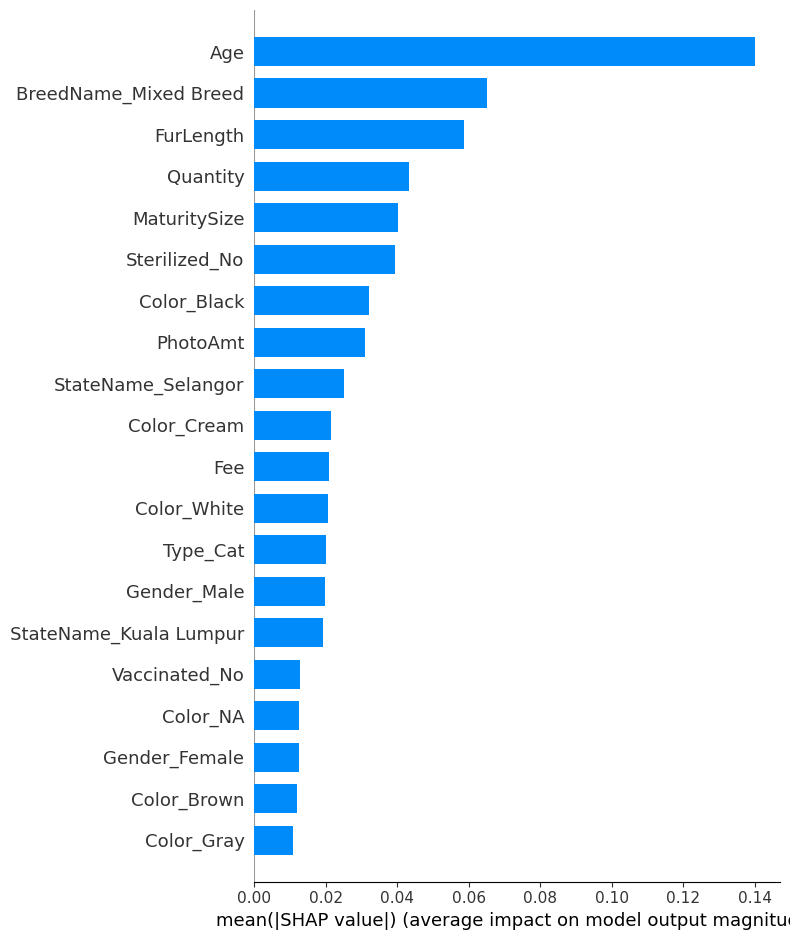

In [366]:
# Generate a bar plot of SHAP values for feature importance
shap.summary_plot(shap_values[0], X_train_structured_std[:100], feature_names=final_tab_data.columns, plot_type="bar")


In [82]:
tr_img_data = tr_img.copy()
tr_img_data.drop('PetID', axis = 1, inplace = True)
tr_img_data = tr_img_data[['ImageName', 'AdoptionSpeed']]
tr_img_data['AdoptionSpeed'] = tr_img_data['AdoptionSpeed'].astype('str')
y = tr_img_data['AdoptionSpeed'].tolist()

In [75]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Assuming you have a DataFrame 'df' with 'img_name' and 'label' columns
# df = pd.DataFrame({'img_name': ['image1.jpg', 'image2.jpg', ...], 'label': [0, 1, ...]})

# Constants
# IMG_WIDTH, IMG_HEIGHT = 64, 64  # Modify based on your needs
# BATCH_SIZE = 32

# # Split the DataFrame into training and validation sets
# train_df, val_df = train_test_split(tr_img_data, test_size=0.25, random_state = 42)  # 25% for validation




In [76]:
train_df

,ImageName,AdoptionSpeed
787,0b57ed86a-1.jpg,1
8737,122683077-1.jpg,1
9109,fa89bfa82-1.jpg,0
822,5afe2ebbc-1.jpg,0
11166,af9325798-1.jpg,0
...,...,...
5315,4f1d0410d-1.jpg,1
13726,5eaee2353-1.jpg,0
5524,d2d48985e-1.jpg,1
888,80ae0a34f-1.jpg,1


In [76]:
from tensorflow.keras import layers
from keras.models import Model
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.losses import MeanSquaredError
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import pandas as pd
# from keras.utils.vis_utils import plot_model
import pickle as pkl
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [77]:
# X_train_structured_std, X_test_structured_std, y_train_std, y_test_std = train_test_split(
#     tr_img_data['ImageName'], tr_img_data['AdoptionSpeed'], test_size=0.25)

In [78]:
train_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

In [79]:
# train_generator = train_datagen.flow_from_dataframe(
#     dataframe=train_df,
#     directory='./train_images',  # Change to your images directory
#     x_col='ImageName',
#     y_col='AdoptionSpeed',
#     target_size=(128, 128),
#     batch_size=BATCH_SIZE,
#     class_mode='binary'  # Use 'categorical' for multi-class classification
# )

In [80]:
import pandas as pd
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16


from keras.layers import BatchNormalization, GlobalAveragePooling2D, Dense, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import MeanSquaredError
from tensorflow.keras.optimizers.schedules import ExponentialDecay
# from keras.utils.vis_utils import plot_model

from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D,MaxPooling1D
from keras.layers import Activation,Dropout,Flatten,BatchNormalization
from keras.models import Sequential
# from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical


In [83]:
tr_img_data = tr_img.copy()
tr_img_data.drop('PetID', axis = 1, inplace = True)
tr_img_data = tr_img_data[['ImageName', 'AdoptionSpeed']]
tr_img_data['AdoptionSpeed'] = tr_img_data['AdoptionSpeed'].astype('str')
y = tr_img_data['AdoptionSpeed'].tolist()

In [84]:
train_df, val_df = train_test_split(tr_img_data, test_size=0.25, random_state = 42)

In [85]:
# from keras.preprocessing.image import ImageDataGenerator
# image_train_generator = ImageDataGenerator(
#         brightness_range=(0.75, 1),
#         shear_range=0.1,
#         zoom_range=[0.75, 1],
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True
#         )
    
# image_test_generator = ImageDataGenerator(rescale = 1./1)

In [86]:
train_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

In [87]:
IMG_WIDTH, IMG_HEIGHT = 128, 128
BATCH_SIZE = 64
# Flow from DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='./train_images',  # Change to your images directory
    x_col='ImageName',
    y_col='AdoptionSpeed',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'  # Use 'categorical' for multi-class classification
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='./train_images',
    x_col='ImageName',
    y_col='AdoptionSpeed',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 10980 validated image filenames belonging to 2 classes.
Found 3660 validated image filenames belonging to 2 classes.


In [126]:
model = InceptionV3(weights="imagenet", include_top=False, 
                    input_tensor=Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)))

In [127]:

for layer in model.layers:
    layer.trainable=False

img_input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
x = model(img_input, training=False)
x = GlobalAveragePooling2D(name="avg_pool")(x)
x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
output_cnn = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense_hidden')(x) #256
last_layer = Dense(1, activation='linear')(output_cnn)

model = Model(inputs=img_input, outputs=last_layer)

batch_size = 64 
epochs = 100
verbose = 1
        

initial_learning_rate = 0.15 

# lr_schedule = ExponentialDecay(
#             initial_learning_rate,
#                 decay_steps=100000,
#             decay_rate=0.96,
#             staircase=True)


model.compile(
    optimizer=Adam(learning_rate=initial_learning_rate, epsilon=1),
    metrics=['accuracy'],  # Changed from 'mse' to 'accuracy' for binary classification
    loss='binary_crossentropy'  # Changed from 'mse' to 'binary_crossentropy'
)


model.summary()

plot_model(model, show_shapes=True, to_file='inceptionV3_image.png')

stop = EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True, mode='min', verbose=1)
best = ModelCheckpoint(filepath='./best_iv3_model_simple.hdf5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

history = model.fit(
    train_generator, 
    validation_data = val_generator,
    batch_size=batch_size,
    verbose=verbose,
    epochs=epochs,
    callbacks=[stop, best]
)


model.save('./best_iv3_model_simple.h5')

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 avg_pool (GlobalAveragePoo  (None, 2048)              0         
 ling2D)                                                         
                                                                 
 batch_normalization_664 (B  (None, 2048)              8192      
 atchNormalization)                                              
                                                                 
 dense_hidden (Dense)        (None, 64)                131136    
                                                                 
 dense_6 (Dense)             (None, 1)                 65 

/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


172/172 [==============================] - 61s 340ms/step - loss: 7.1683 - accuracy: 0.5170 - val_loss: 7.4864 - val_accuracy: 0.5074
Epoch 2/100
172/172 [==============================] - ETA: 0s - loss: 7.3574 - accuracy: 0.5188
Epoch 2: val_loss improved from 7.48639 to 7.21596, saving model to ./best_iv3_model_simple.hdf5
172/172 [==============================] - 57s 333ms/step - loss: 7.3574 - accuracy: 0.5188 - val_loss: 7.2160 - val_accuracy: 0.5270
Epoch 3/100
172/172 [==============================] - ETA: 0s - loss: 7.1468 - accuracy: 0.5321
Epoch 3: val_loss did not improve from 7.21596
172/172 [==============================] - 57s 329ms/step - loss: 7.1468 - accuracy: 0.5321 - val_loss: 7.3186 - val_accuracy: 0.5219
Epoch 4/100
172/172 [==============================] - ETA: 0s - loss: 7.2369 - accuracy: 0.5277
Epoch 4: val_loss did not improve from 7.21596
172/172 [==============================] - 57s 330ms/step - loss: 7.2369 - accuracy: 0.5277 - val_loss: 7.5041 - val

In [102]:
model.save('./best_iv3_model_simple.h5')

In [103]:
history.save('./best_iv3_model_simplehist.h5')

AttributeError: 'History' object has no attribute 'save'

In [104]:
from keras.models import Model
import keras
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import numpy as np

In [108]:
def find_target_layer(model_pretrained):
    # attempt to find the final convolutional layer in the network
    # by looping over the layers of the network in reverse order
    for layer in reversed(model_pretrained.layers):
        # check to see if the layer has a 4D output
        if len(layer.output_shape) == 4:
            return layer.name
    # otherwise, we could not find a 4D layer so the GradCAM
    # algorithm cannot be applied
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

def compute_heatmap_inceptionV3(model_pretrained, image, eps=1e-8):
    # construct our gradient model by supplying (1) the inputs
    # to our pre-trained model, (2) the output of the (presumably)
    # final 4D layer in the network, and (3) the output of the
    # softmax activations from the model
    
    gradModel = Model(
        inputs=[model_pretrained.get_layer('inception_v3').inputs],
        outputs=[model_pretrained.get_layer('inception_v3').get_layer(find_target_layer(model_pretrained.get_layer('inception_v3'))).output,
            model_pretrained.get_layer('inception_v3').output])
    
    # record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # cast the image tensor to a float-32 data type, pass the
        # image through the gradient model, and grab the loss
        # associated with the specific class index
        inputs = tf.cast(image, tf.float32)
        (convOutputs, predictions) = gradModel(inputs)
        loss = predictions[:, 0]
    # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    # grab the spatial dimensions of the input image and resize
    # the output class activation map to match the input image
    # dimensions
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    # normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
    # return the resulting heatmap to the calling function
    return heatmap
  
fine_tuned_inceptionv3 = keras.models.load_model('./best_iv3_model_simple.hdf5', compile=False)

for img_file in ["./train_images/0b57ed86a-1.jpg",
                 "./train_images/122683077-1.jpg", 
                "./train_images/fa89bfa82-1.jpg"]:
    img = load_img(img_file, target_size=(128, 128))
    img = img_to_array(img)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img_cv2 = cv2.imread(img_file, 0)
    img_cv2 = cv2.resize(img_cv2, (128, 128))
    img_cv2.shape
    
    
    img_heatmap = compute_heatmap_inceptionV3(fine_tuned_inceptionv3, img, eps=1e-8)
    img_heatmap.shape
    
    colormap=cv2.COLORMAP_TURBO
    alpha = 0.43
    heatmap = cv2.applyColorMap(img_heatmap, colormap, 0)[:, :, 0]
    output = cv2.addWeighted(img_cv2, alpha, heatmap, 1 - alpha, 0)
    final_output = (heatmap, output)
    
    plt.imsave(img_file.replace('/train_images', '').replace('.jpg', '') + '_gradcam.png', output, dpi = 500)
    plt.imshow(output)
    plt.close()

ValueError: Input 0 of layer "model_9" is incompatible with the layer: expected shape=(None, 128, 128, 3), found shape=(1, 299, 299, 3)

In [106]:
print(img_cv2.shape)
print(heatmap.shape)

# Resize heatmap to match img_cv2 if they differ
if img_cv2.shape != heatmap.shape:
    heatmap = cv2.resize(heatmap, (img_cv2.shape[1], img_cv2.shape[0]))


(299, 299)
(128, 128)


In [88]:

# train_datagen = ImageDataGenerator(
#     rescale=1./255#,  # Scale images from 0-255 to 0-1
# #     rotation_range=20,  # Random rotation
# #     width_shift_range=0.2,  # Random horizontal shifting
# #     height_shift_range=0.2,  # Random vertical shifting
# #     shear_range=0.2,  # Shear transformations
# #     zoom_range=0.2,  # Random zooming
# #     horizontal_flip=True,  # Random horizontal flips
# #     fill_mode='nearest'
#  )

# val_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
IMG_WIDTH, IMG_HEIGHT = 128, 128
BATCH_SIZE = 32
# Flow from DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='./train_images',  # Change to your images directory
    x_col='ImageName',
    y_col='AdoptionSpeed',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'  # Use 'categorical' for multi-class classification
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='./train_images',
    x_col='ImageName',
    y_col='AdoptionSpeed',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


In [ ]:
class SaveAtMinValLoss(tf.keras.callbacks.Callback):
    def __init__(self, save_path):
        super(SaveAtMinValLoss, self).__init__()
        self.save_path = save_path
        self.min_val_loss = float('inf')  # Initialize with positive infinity

    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get('val_loss')
        if current_val_loss < self.min_val_loss:  # Check if current validation loss is lower than min
            self.min_val_loss = current_val_loss
            self.model.save(self.save_path, overwrite=True)  # Save the model
            print(f"\nEpoch {epoch+1}: saving model to {self.save_path}")

# Then create an instance of this updated callback
save_at_min_val_loss = SaveAtMinValLoss(save_path)

# And use it in your model.fit call
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    epochs=20,  # Modify based on your needs
    validation_data=val_generator,
    validation_steps=len(val_df) // BATCH_SIZE,
    callbacks=[save_at_min_val_loss]
)

In [90]:
class SaveAtMaxValLoss(tf.keras.callbacks.Callback):
    def __init__(self, save_path):
        super(SaveAtMaxValLoss, self).__init__()
        self.save_path = save_path
        self.max_val_loss = float('-inf')  # Initialize with negative infinity

    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get('val_loss')
        if current_val_loss > self.max_val_loss:  # Check if current validation loss is greater than max
            self.max_val_loss = current_val_loss
            self.model.save(self.save_path, overwrite=True)  # Save the model
            print(f"\nEpoch {epoch+1}: saving model to {self.save_path}")

# Define the model (example model, modify as needed)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])
save_path = './cnn.h5' 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
save_at_max_val_loss = SaveAtMaxValLoss(save_path)
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_df) // BATCH_SIZE,  # Number of batches per epoch
    epochs=20,  # Modify based on your needs
    validation_data=val_generator,
    validation_steps=len(val_df) // BATCH_SIZE,  # Number of validation batches
    callbacks=[save_at_max_val_loss]
)

Epoch 1/20
343/343 [==============================] - ETA: 0s - loss: 0.6968 - accuracy: 0.5083

/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 1: saving model to ./cnn.h5
343/343 [==============================] - 2228s 7s/step - loss: 0.6968 - accuracy: 0.5083 - val_loss: 0.6919 - val_accuracy: 0.5069
Epoch 2/20
343/343 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5071
Epoch 2: saving model to ./cnn.h5
343/343 [==============================] - 46s 134ms/step - loss: 0.6933 - accuracy: 0.5071 - val_loss: 0.6927 - val_accuracy: 0.5066
Epoch 3/20
343/343 [==============================] - 45s 131ms/step - loss: 0.6935 - accuracy: 0.5059 - val_loss: 0.6916 - val_accuracy: 0.5071
Epoch 4/20
343/343 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.5127
Epoch 4: saving model to ./cnn.h5
343/343 [==============================] - 45s 132ms/step - loss: 0.6926 - accuracy: 0.5127 - val_loss: 0.6929 - val_accuracy: 0.5101
Epoch 5/20
343/343 [==============================] - ETA: 0s - loss: 0.6894 - accuracy: 0.5280
Epoch 5: saving model to ./cnn.h5
343/343 [====================

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [82]:
import tensorflow as tf

print("Built with CUDA: ", tf.test.is_built_with_cuda())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

if tf.config.list_physical_devices('GPU'):
    print("Default GPU Device: ", tf.test.gpu_device_name())
else:
    print("No GPU device found.")


Built with CUDA:  True
Num GPUs Available:  0
No GPU device found.


In [80]:
import torch

In [81]:
import torch

# Check if CUDA (GPU support) is available in PyTorch
print("Is CUDA available in PyTorch: ", torch.cuda.is_available())
print("Num GPUs Available: ", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current CUDA Device: ", torch.cuda.current_device())
    print("CUDA Device Name: ", torch.cuda.get_device_name(torch.cuda.current_device()))


Is CUDA available in PyTorch:  True
Num GPUs Available:  1
Current CUDA Device:  0
CUDA Device Name:  NVIDIA A10


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback

# Custom callback to save the model with the highest validation loss
class SaveAtMaxValLoss(Callback):
    def __init__(self, save_path):
        super(SaveAtMaxValLoss, self).__init__()
        self.save_path = save_path
        self.max_val_loss = float('-inf')

    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get('val_loss')
        if current_val_loss > self.max_val_loss:
            self.max_val_loss = current_val_loss
            self.model.save(self.save_path, overwrite=True)
            print(f"\nEpoch {epoch+1}: saving model to {self.save_path}")

# Make sure a GPU is available
if tf.config.list_physical_devices('GPU'):
    print('GPU is available.')
    with tf.device('/GPU:0'):  # Specify the GPU to use
        # Define and compile the model inside this block
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
            MaxPooling2D(2, 2),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D(2, 2),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D(2, 2),
            Flatten(),
            Dropout(0.5),
            Dense(128, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Define the save path and the callback
        save_path = './cnn.h5'
        save_at_max_val_loss = SaveAtMaxValLoss(save_path)

        # Train the model within this GPU context
        history = model.fit(
            train_generator,
            steps_per_epoch=len(train_df) // BATCH_SIZE,
            epochs=25,
            validation_data=val_generator,
            validation_steps=len(val_df) // BATCH_SIZE,
            callbacks=[save_at_max_val_loss]
        )
else:
    print('GPU is not available. Training on CPU.')


In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Define the PyTorch CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, activation='relu')
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, activation='relu')
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, activation='relu')
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * x * y, 128)  # x and y depend on your input size after conv and pool layers
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Instantiate the model
model = CNN()
if torch.cuda.is_available():
    model.cuda()  # Move model to GPU if available

TypeError: Conv2d.__init__() got an unexpected keyword argument 'activation'

In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Remove activation parameter
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Remove activation parameter
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Remove activation parameter
        # Flatten layer is implicit in the forward method
        self.dropout = nn.Dropout(0.5)
        # You'll need to calculate the correct size here based on your input dimensions
        self.fc1 = nn.Linear(128 * final_dim * final_dim, 128)  # Update 'final_dim' based on your input dimensions
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten the layer
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze()  # Adjust based on your loss function, remove for BCEWithLogitsLoss

# Instantiate the model
model = CNN()
if torch.cuda.is_available():
    model.cuda()  # Move model to GPU if available


NameError: name 'final_dim' is not defined

In [ ]:
import pandas as pd
import numpy as np
import pickle as pkl

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# keras imports
from keras.models import Model


# filter warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from keras.layers import Input, Attention, Embedding, Dropout, Dense , Bidirectional, LSTM
from keras.initializers import Constant
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from keras.losses import MeanSquaredError
#from keras.utils import plot_model, Sequence
from tensorflow.keras.optimizers.schedules import ExponentialDecay


from keras.utils.vis_utils import plot_model


from keras.preprocessing.sequence import pad_sequences


from category_encoders import *

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim = 32, num_heads = 2, ff_dim = 32, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'rate': self.rate,
            'att': self.att,
            'ffn': self.ffn,
            'layernorm1': self.layernorm1,
            'layernorm2': self.layernorm2,
            'dropout1': self.dropout1,
            'dropout2': self.dropout2
        })
        return config

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen = 100, vocab_size = 1000, embed_dim = 125):
        super(TokenAndPositionEmbedding, self).__init__()
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'maxlen': self.maxlen,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim,
            'token_emb': self.token_emb,
            'pos_emb': self.pos_emb
        })
        return config

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

def prepare_text_data_train(dataf):
    for col in dataf.columns:
        dataf[col] = dataf[col].str.lower()
        
        tokenizer = Tokenizer(num_words=2096) #5000
        tokenizer.fit_on_texts(dataf[col])
        pkl.dump(tokenizer, open('/data/model/text_tokenizer.pkl','wb'))
        
        vocab_size = len(tokenizer.word_index) + 1 
        print(vocab_size)
        
        pkl.dump(vocab_size, open('/data/model/text_vocab_size.pkl','wb'))

        maxlen = int(np.mean(dataf[col].str.len()))
        pkl.dump(maxlen, open('/data/model/text_maxlen.pkl','wb'))

def prepare_text_data_inference(dataf):
    for col in dataf.columns:
        dataf[col] = dataf[col].str.lower()
        
        file = open("/data/model/text_tokenizer.pkl",'rb')
        tokenizer = pkl.load(file)
        file.close()
        
        data_tokens = tokenizer.texts_to_sequences(dataf[col])
        
        file = open("/data/model/text_vocab_size.pkl",'rb')
        vocab_size = pkl.load(file)
        file.close()
        
        file = open("/data/model/text_maxlen.pkl",'rb')
        maxlen = pkl.load(file)
        file.close()

        data_tokens_pad = pad_sequences(data_tokens, padding='post', maxlen=max(maxlen, 300), truncating='post')
        
    return data_tokens_pad, data_tokens, vocab_size, max(maxlen, 300)


X_train_text = pd.read_csv('/data/X_train_text.csv', sep = ';')
X_test_text = pd.read_csv('/data/X_test_text.csv', sep = ';')

y_train_std = pd.read_csv('/data/y_train_std.csv', sep = ';')
y_test_std = pd.read_csv('/data/y_test_std.csv', sep = ';')

del X_train_text['Unnamed: 0']
del X_test_text['Unnamed: 0']

print('TRAIN', len(X_train_text), len(y_train_std))
print('TEST', len(X_test_text), len(y_test_std))


prepare_text_data_train(X_train_text)
train_tokens_pad, train_tokens, vocab_size, maxlen = prepare_text_data_inference(X_train_text)
test_tokens_pad, test_tokens, vocab_size, maxlen = prepare_text_data_inference(X_test_text)

file = open("/data/model/text_tokenizer.pkl",'rb')
tokenizer = pkl.load(file)
file.close()



##### LOAD GLOVE EMBEDDINGS
print('glove load...')
# identify the embedding filename; we are using the Glove 42B 300d embeddings
glove_file = "/data/model/glove.840B.300d.txt"
print('glove loaded!')
# create the embeddings index dictionary
embeddings_index = {} # create a lookup dictionary to store words and their vectors
f = open(glove_file, errors='ignore')# open our embedding file 
for line in f: # for each line in the file
    values = line.split(' ') #split the line on spaces between the word and its vectors
    word = values[0] # the word is the first entry
    if word in tokenizer.word_index.keys(): # we check if the word is in our tokenizer word index
        coefs = np.asarray(values[1:], dtype='float32') # if so, get the word's vectors
        embeddings_index[word] = coefs # add the word and its vectors to the embeddings_index dictionary
f.close()
print('Found %s word vectors.' % len(embeddings_index)) # report how many words in our corpus were found in the GloVe words

# amount of vocabulary to use, will pick the top 10000 words seen in the corpus
features = 10000
# max text sequence length, must match tokens in transfer file, we are using glove 300d so it is 300
max_words = 300

num_tokens = (len(tokenizer.word_index) + 1) # for num tokens we always do the length of our word index +1 for a pad token
hits = 0
misses = 0
embedding_dim = 300

embedding_matrix = np.zeros((num_tokens, max_words)) # setting up an array for our tokens with a row per token and 300 columns
for word, i in tokenizer.word_index.items(): # for each word in the tokenizer word index
    embedding_vector = embeddings_index.get(word) #get the vector from the embeddings index dictionary
    if embedding_vector is not None: # if the vector isn't None,
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector # store the embedding vector in the matrix at that index
        hits += 1
    else:
        misses += 1        
print("Converted %d words (%d misses)" % (hits, misses))


####### CREATING TEXT NEURAL NETWORK ARCHITECTURE WITH GLOVE EMBEDDINGS
# for text embeddings the input shape can be none
nlp_input = Input(shape=(maxlen,), name='nlp_input')

# uses the embedding matrix dictionary to create word embeddings for the inputs
embedded_sequences = Embedding(
                input_dim = num_tokens, # number of unique tokens
                output_dim = embedding_dim, #number of features
                embeddings_initializer=Constant(embedding_matrix), # initialize with Glove embeddings
                input_length=maxlen, 
                trainable=False)(nlp_input)
# uses two bi-directional LSTM layers
lstm = Bidirectional(LSTM(300, return_sequences=True))(embedded_sequences)
att_lstm = Attention(units=300)(lstm)
nlp_out = Dropout(0.5)(att_lstm)
# adds a dense layer
#output_embed = Dense(350, activation="relu", kernel_initializer='he_normal')(x)
last_layer = Dense(1, activation='linear')(nlp_out)

# declare the final model inputs and outputs
final_model = Model(inputs=nlp_input, outputs=last_layer)

# print a summary of the model
print(final_model.summary())

# set up learning rate decay schedule
initial_learning_rate = 0.1
lr_schedule = ExponentialDecay(
    initial_learning_rate,
        decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

stop = EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True, mode='min', verbose=1)
best = ModelCheckpoint(filepath='/data/model/best_nlp_model.hdf5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# compile the model
final_model.compile(optimizer=Adam(learning_rate=lr_schedule, epsilon=1), 
                    loss="mean_squared_error", 
                    metrics=[MeanSquaredError()])

plot_model(final_model, show_shapes=True, to_file='model2_nlp_attention.png')

results = final_model.fit(
            train_tokens_pad, y_train_std,
            epochs=500,
            callbacks=[stop, best],
            validation_data=([test_tokens_pad, y_test_std])
            )

final_model.save('/data/model/pretrained_nlp_model.h5')


## BERT MODEL

In [67]:
%%capture
!pip install transformers

In [68]:
from transformers import BertTokenizer
from transformers import AutoTokenizer
import tensorflow as tf
from transformers import TFAutoModel
import numpy as np

In [69]:
tr_text.head()

,Description,AdoptionSpeed
0,Nibble is a 3+ month old ball of cuteness. He ...,1
1,I just found it alone yesterday near my apartm...,1
2,Their pregnant mother was dumped by her irresp...,0
3,"Good guard dog, very alert, active, obedience ...",1
4,This handsome yet cute boy is up for adoption....,1


In [70]:
df = tr_text.copy()
train_ds, val_ds = train_test_split(df, test_size=0.25, random_state = 42)

In [140]:
pip install pydot graphviz

  Obtaining dependency information for pydot from https://files.pythonhosted.org/packages/7f/90/c9b51f3cdff89cd8f93382060330f43d1af098a6624cff439e700791e922/pydot-2.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/de/5e/fcbb22c68208d39edff467809d06c9d81d7d27426460ebc598e55130c1aa/graphviz-0.20.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 39.3 kB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [141]:
from transformers import BertTokenizer, TFAutoModel
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

# Assuming tr_text is already defined and a copy of your DataFrame
df = tr_text.copy()

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
SEQ_LEN = 512  # Adjust sequence length to BERT's maximum
encoded_inputs = tokenizer(df['Description'].tolist(),
                           add_special_tokens=True,
                           padding='max_length',
                           truncation=True,
                           max_length=SEQ_LEN,
                           return_token_type_ids=False,
                           return_tensors='tf')

def map_bert(inputs, labels):
    return {'input_ids': inputs['input_ids'], 'attention_mask': inputs['attention_mask']}, labels

# Prepare the dataset
train_dataset = tf.data.Dataset.from_tensor_slices((encoded_inputs, df['AdoptionSpeed'].values))
train_dataset = train_dataset.map(map_bert)
dataset = train_dataset.shuffle(100000).batch(64)
DS_LEN = len(dataset)

SPLIT = 0.75
train_ds = dataset.take(round(DS_LEN * SPLIT))
val_ds = dataset.skip(round(DS_LEN * SPLIT))

# Initialize the BERT model
bert = TFAutoModel.from_pretrained('bert-base-uncased')

# Define the model architecture
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=tf.int32, name='input_ids')
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=tf.int32, name='attention_mask')
embeddings = bert([input_ids, mask])[0]
cls_token = embeddings[:, 0, :]
x = tf.keras.layers.BatchNormalization()(cls_token)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
y = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# Freeze the BERT layer to avoid retraining it
model.layers[2].trainable = False

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.BinaryCrossentropy()
metric = tf.keras.metrics.BinaryAccuracy(name='accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Set up the callbacks including the ModelCheckpoint
callbacks = [
    ReduceLROnPlateau(patience=2, factor=0.1, min_delta=0.001, monitor='val_loss'),
    EarlyStopping(patience=5, min_delta=0.001, monitor='val_loss'),
    ModelCheckpoint(filepath='./best_nlp_model.hdf5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
]

# Visualize the model architecture
plot_model(model, show_shapes=True, to_file='./model2_nlp_attention.png')

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callbacks
)

# Evaluate the model on the validation dataset
model.evaluate(val_ds)

# Since 'final_model' is not defined in your code, assuming you meant 'model'
model.save('./pretrained_nlp_model.h5')


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/25


KeyboardInterrupt: 

In [ ]:
stop = EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True, mode='min', verbose=1)
best = ModelCheckpoint(filepath='/data/model/best_nlp_model.hdf5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# compile the model
final_model.compile(optimizer=Adam(learning_rate=lr_schedule, epsilon=1), 
                    loss="mean_squared_error", 
                    metrics=[MeanSquaredError()])

plot_model(final_model, show_shapes=True, to_file='model2_nlp_attention.png')

results = final_model.fit(
            train_tokens_pad, y_train_std,
            epochs=500,
            callbacks=[stop, best],
            validation_data=([test_tokens_pad, y_test_std])
            )

final_model.save('/data/model/pretrained_nlp_model.h5')

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFAutoModel
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Load and prepare your data
df = tr_text.copy()

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
SEQ_LEN = 1280  # Ensure this is the intended sequence length
encoded_inputs = tokenizer(df['Description'].tolist(),
                           add_special_tokens=True,
                           padding='max_length',
                           truncation=True,
                           max_length=SEQ_LEN,
                           return_token_type_ids=False,
                           return_tensors='tf')

def map_bert(inputs, labels):
    return {'input_ids': inputs['input_ids'], 'attention_mask': inputs['attention_mask']}, labels

train_dataset = tf.data.Dataset.from_tensor_slices((encoded_inputs, df['AdoptionSpeed'].values))
train_dataset = train_dataset.map(map_bert)
train_ds = train_dataset.shuffle(10000).batch(64)
val_ds = ...  # Make sure you have a validation dataset

# Define the model
bert = TFAutoModel.from_pretrained('bert-base-uncased')

input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=tf.int32, name='input_ids')
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=tf.int32, name='attention_mask')

embeddings = bert([input_ids, mask])[0]
cls_token = embeddings[:, 0, :]

x = tf.keras.layers.BatchNormalization()(cls_token)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
y = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model.layers[2].trainable = False
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss=BinaryCrossentropy(),
              metrics=[BinaryAccuracy(name='accuracy')])

# Define your callbacks including ModelCheckpoint
callbacks = [
    ReduceLROnPlateau(patience=2, factor=0.1, min_delta=0.001, monitor='val_loss'),
    EarlyStopping(patience=5, min_delta=0.001, monitor='val_loss'),
    ModelCheckpoint(filepath='/content/best_model.h5', monitor='val_loss', save_best_only=True)
]

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callbacks
)

# Evaluate the best model
best_model = tf.keras.models.load_model('/content/best_model.h5')
best_model.evaluate(val_ds)


In [134]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [135]:
# Define the checkpoint directory and file name
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.1, min_delta=0.001, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(patience=5, min_delta=0.001, monitor='val_loss'),
    model_checkpoint_callback  # Add the checkpoint callback here
]

In [130]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFAutoModel

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFAutoModel

# Load the dataset
df = pd.read_csv("/content/pet_text_data.csv")

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
SEQ_LEN = 1280  # Set sequence length

# Encode the descriptions
encoded_inputs = tokenizer(df['Description'].tolist(),
                           add_special_tokens=True,
                           padding='max_length', 
                           truncation=True, 
                           max_length=SEQ_LEN, 
                           return_token_type_ids=False,
                           return_tensors='tf')

# Prepare the TensorFlow dataset
def map_bert(inputs, labels):
    return {'input_ids': inputs['input_ids'], 'attention_mask': inputs['attention_mask']}, labels

# Assuming df['AdoptionSpeed'] contains binary labels; if not, you'll need to adjust this.
train_dataset = tf.data.Dataset.from_tensor_slices((encoded_inputs, df['AdoptionSpeed'].values))
train_dataset = train_dataset.map(map_bert).shuffle(100000).batch(64)

# Load the BERT model
bert = TFAutoModel.from_pretrained('bert-base-uncased')

# Define model inputs
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=tf.int32, name='input_ids')
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=tf.int32, name='attention_mask')

# Define the model architecture
embeddings = bert([input_ids, mask])[0]
cls_token = embeddings[:, 0, :]
x = tf.keras.layers.BatchNormalization()(cls_token)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
y = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

# Construct the final model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model.layers[2].trainable = False  # Freeze the BERT layer
model.summary()

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.BinaryCrossentropy()
metric = tf.keras.metrics.BinaryAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Prepare callbacks
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.1, min_delta=0.001, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(patience=5, min_delta=0.001, monitor='val_loss')
]

# Fit the model (make sure train_ds and val_ds are defined and formatted correctly)
# Assuming train_ds is defined and formatted correctly; replace 'train_ds' with 'train_dataset' if using above dataset
# Ensure 'val_ds' is also defined following similar procedure for validation data
history = model.fit(
    train_dataset,
    validation_data=val_ds,  # This needs to be defined similarly to train_dataset
    epochs=25,
    callbacks=callbacks
)

# Evaluate the model
model.evaluate(val_ds)  # Make sure val_ds is properly prepared


# MULTI-MODAL code

In [65]:
import pandas as pd
import numpy as np
import pickle as pkl

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.layers import BatchNormalization, Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling2D, Activation, Dropout, Dense, Input, Multiply
from keras.models import Sequential, Model
from keras.regularizers import l2, l1
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, History, LearningRateScheduler
from keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredError
#from keras.utils import plot_model, Sequence
from keras.initializers import Constant
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from tensorflow.keras.layers import Attention
import keras

In [66]:
tr_tab

,Type,Age,Breed1,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed
0,2,3,299,1,1,7,0,1,1,2,2,2,1,1,100,41326,0,1.0,1
1,2,1,265,1,1,2,0,2,2,3,3,3,1,1,0,41401,0,2.0,1
2,1,1,307,1,2,7,0,2,2,1,1,2,1,1,0,41326,0,7.0,0
3,1,4,307,2,1,2,0,2,1,1,1,2,1,1,150,41401,0,8.0,1
4,1,1,307,1,1,0,0,2,1,2,2,2,1,1,0,41326,0,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14975,2,2,266,3,1,0,0,2,2,2,2,2,1,4,0,41326,0,3.0,1
14976,2,60,265,3,1,4,7,2,2,1,1,1,1,2,0,41326,0,3.0,0
14977,2,2,265,3,5,6,7,3,2,2,1,3,1,5,30,41326,0,5.0,0
14978,2,9,266,2,4,7,0,1,1,1,1,1,1,1,0,41336,0,3.0,0


In [67]:
final_tab_data

,Age,MaturitySize,FurLength,Health,Quantity,Fee,VideoAmt,PhotoAmt,AdoptionSpeed,BreedName_Calico,...,StateName_Pulau Pinang,StateName_Selangor,Sterilized_No,Sterilized_NotSure,Sterilized_Yes,Type_Cat,Type_Dog,Vaccinated_No,Vaccinated_NotSure,Vaccinated_Yes
0,3,1,1,1,1,100,0,1.0,1,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1,2,2,1,1,0,0,2.0,1,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1,2,2,1,1,0,0,7.0,0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,4,2,1,1,1,150,0,8.0,1,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1,2,1,1,1,0,0,3.0,1,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,2,2,2,1,4,0,0,3.0,1,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
14636,60,2,2,1,2,0,0,3.0,0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
14637,2,3,2,1,5,30,0,5.0,0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
14638,9,1,1,1,1,0,0,3.0,0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [68]:
tr_img

,PetID,AdoptionSpeed,ImageName
0,86e1089a3,1,86e1089a3-1.jpg
1,6296e909a,1,6296e909a-1.jpg
2,3422e4906,0,3422e4906-1.jpg
3,5842f1ff5,1,5842f1ff5-1.jpg
4,850a43f90,1,850a43f90-1.jpg
...,...,...,...
14975,dc0935a84,1,dc0935a84-1.jpg
14976,a01ab5b30,0,a01ab5b30-1.jpg
14977,d981b6395,0,d981b6395-1.jpg
14978,e4da1c9e4,0,e4da1c9e4-1.jpg


In [69]:
tr_text

,Description,AdoptionSpeed
0,Nibble is a 3+ month old ball of cuteness. He ...,1
1,I just found it alone yesterday near my apartm...,1
2,Their pregnant mother was dumped by her irresp...,0
3,"Good guard dog, very alert, active, obedience ...",1
4,This handsome yet cute boy is up for adoption....,1
...,...,...
14975,I have 4 kittens that need to be adopt urgentl...,1
14976,Serato(female cat- 3 color) is 4 years old and...,0
14977,"Mix breed, good temperament kittens. Love huma...",0
14978,she is very shy..adventures and independent..s...,0


In [70]:
X_train_structured_std, X_test_structured_std, y_train_std, y_test_std = train_test_split(final_tab_data.drop('AdoptionSpeed', axis = 1), tab_data_y, test_size = 0.25, random_state = 42)
tr_img_data = tr_img.copy()
tr_img_data.drop('PetID', axis = 1, inplace = True)
tr_img_data['AdoptionSpeed'] = tr_img_data['AdoptionSpeed'].astype('str')

X_train_image, X_test_image = train_test_split(tr_img_data['ImageName'], test_size = 0.25, random_state = 42)

df = tr_text.copy()
X_train_text, X_test_text = train_test_split(df['Description'], test_size=0.25, random_state = 42)

In [71]:
X_train_text

787      Name : Meowzer Age : 1 year old. Type : Mix of...
8737     This dear boy was found in Subang recently, lo...
9109     Bambee is still a playful and gentle young dog...
822      LOOKING FOR NEW OWNER THAT SERIOUSLY WANT TO A...
11166    Sunny was born to a litter of 4 pups of a stra...
                               ...                        
5315     Believe it or not, I found this kitten walking...
13726    Mia has given birth to 4 lovely kittens on 27 ...
5524     Sally is a cheerful and smart dog that looks l...
888      Two love cats, is some ways husband and wife. ...
7452                        crossbreed of rottweiler .....
Name: Description, Length: 10980, dtype: object

In [72]:
print('TRAIN', len(X_train_structured_std), len(X_train_image), len(X_train_text), len(y_train_std))
print('TEST', len(X_test_structured_std), len(X_test_image), len(X_test_text), len(y_test_std))


TRAIN 10980 10980 10980 10980
TEST 3660 3660 3660 3660


In [73]:
X_train_image = X_train_image.apply(lambda x: './train_images/'+str(x))
X_test_image = X_test_image.apply(lambda x: './train_images/'+str(x))

In [74]:
X_train_image

787      ./train_images/0b57ed86a-1.jpg
8737     ./train_images/122683077-1.jpg
9109     ./train_images/fa89bfa82-1.jpg
822      ./train_images/5afe2ebbc-1.jpg
11166    ./train_images/af9325798-1.jpg
                      ...              
5315     ./train_images/4f1d0410d-1.jpg
13726    ./train_images/5eaee2353-1.jpg
5524     ./train_images/d2d48985e-1.jpg
888      ./train_images/80ae0a34f-1.jpg
7452     ./train_images/1819e298c-1.jpg
Name: ImageName, Length: 10980, dtype: object

In [115]:
# def load_house_images(X_image, image_size):
#     # initialize our images array (i.e., the house images themselves)
#     images = []
#     # loop over the indexes of the houses
#     for i, image_file in enumerate(X_image):
        
#         # find the four images for the house and sort the file paths,
#         # ensuring the four are always in the *same order*
#         # initialize our list of input images along with the output image
#         # after *combining* the four input images
#         inputImages = []
#         # loop over the input house paths
#         img = load_img(image_file, target_size=(image_size, image_size))
#         img = img_to_array(img)
#         img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
        
#         if i%1000 == 0:
#             print(i, image_file, img.shape)
#         elif i == 0:
#             print(i, image_file, img.shape)
            
#         images.append(img)
#         # tile the four input images in the output image such the first
#         # image goes in the top-right corner, the second image in the
#         # top-left corner, the third image in the bottom-right corner,
#         # and the final image in the bottom-left corner
#         # return our set of images
#     images = np.array(images)
#     images = images.reshape((len(images), image_size, image_size, 3))
#     return images



# X_train_image_array = load_house_images(X_train_image, image_size = 128)
# X_test_image_array = load_house_images(X_test_image, image_size = 128)

0 ./train_images/51d815775-1.jpg (1, 128, 128, 3)
1000 ./train_images/2befe2607-1.jpg (1, 128, 128, 3)
2000 ./train_images/e1d40ecc1-1.jpg (1, 128, 128, 3)
3000 ./train_images/27bbc8c4f-1.jpg (1, 128, 128, 3)


In [118]:
# pkl.dump(X_train_image_array, open('./model/X_train_image_array.pkl','wb'))
# pkl.dump(X_test_image_array, open('./model/X_test_image_array.pkl','wb'))

In [117]:
file = open("./model/X_train_image_array.pkl",'rb')
X_train_image_array = pkl.load(file)
file.close()
        
file = open("./model/X_test_image_array.pkl",'rb')
X_test_image_array = pkl.load(file)
file.close()

In [100]:
def prepare_text_data_train(dataf):
    dataf = dataf.str.lower()
        
    tokenizer = Tokenizer(num_words=2096) #5000
    tokenizer.fit_on_texts(dataf)
    pkl.dump(tokenizer, open('./model/text_tokenizer.pkl','wb'))
    
    vocab_size = len(tokenizer.word_index) + 1 
    print(vocab_size)
    
    pkl.dump(vocab_size, open('./model/text_vocab_size.pkl','wb'))

    maxlen = int(np.mean(dataf.str.len()))
    pkl.dump(maxlen, open('./model/text_maxlen.pkl','wb'))

def prepare_text_data_inference(dataf):
    dataf = dataf.str.lower()
        
    file = open("./model/text_tokenizer.pkl",'rb')
    tokenizer = pkl.load(file)
    file.close()
    
    data_tokens = tokenizer.texts_to_sequences(dataf)
    
    file = open("./model/text_vocab_size.pkl",'rb')
    vocab_size = pkl.load(file)
    file.close()
    
    file = open("./model/text_maxlen.pkl",'rb')
    maxlen = pkl.load(file)
    file.close()

    data_tokens_pad = pad_sequences(data_tokens, padding='post', maxlen=max(maxlen, 300), truncating='post')
        
    return data_tokens_pad, data_tokens, vocab_size, max(maxlen, 300)

# prepare_text_data_train(X_train_text)
train_tokens_pad, train_tokens, vocab_size, maxlen = prepare_text_data_inference(X_train_text)
test_tokens_pad, test_tokens, vocab_size, maxlen = prepare_text_data_inference(X_test_text)

file = open("./model/text_tokenizer.pkl",'rb')
tokenizer = pkl.load(file)
file.close()

In [103]:
vocab_size


18869

In [126]:
maxlen

343

# tr_text

In [75]:
from transformers import TFAutoModel
from transformers import TFBertModel
fine_tuned_bert = tf.keras.models.load_model('./model/best_nlp_model.hdf5', compile=False, 
                                             custom_objects={'TFBertModel': TFBertModel})


ModuleNotFoundError: No module named 'transformers'

In [76]:
pip install transformers

  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/b6/4d/fbe6d89fde59d8107f0a02816c4ac4542a8f9a85559fdf33c68282affcc1/transformers-4.38.2-py3-none-any.whl.metadata
  Using cached transformers-4.38.2-py3-none-any.whl.metadata (130 kB)
  Obtaining dependency information for huggingface-hub<1.0,>=0.19.3 from https://files.pythonhosted.org/packages/47/8f/cf6683de320cf3873850ba48b7383db96958fe435b8e227db92119f6d867/huggingface_hub-0.21.3-py3-none-any.whl.metadata
  Using cached huggingface_hub-0.21.3-py3-none-any.whl.metadata (13 kB)
  Obtaining dependency information for tokenizers<0.19,>=0.14 from https://files.pythonhosted.org/packages/15/0b/c09b2c0dc688c82adadaa0d5080983de3ce920f4a5cbadb7eaa5302ad251/tokenizers-0.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached tokenizers-0.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Obtaining dependency information for safetensor

In [147]:
import keras
from keras.models import Model
from keras.layers import Dense, concatenate
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy, MeanSquaredError
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

# If Attention is a custom layer used in your BERT model, ensure it's correctly imported
# from your_attention_module import Attention
# For example, if it's part of transformers, adjust the import according to your needs
from transformers import TFAutoModel  # This is just an example

# Load pre-trained models without compilation
fine_tuned_inceptionv3 = keras.models.load_model('./model/best_iv3_model_simple.hdf5', compile=False)
# fine_tuned_bert = keras.models.load_model('./model/best_nlp_model.hdf5',
#                                           compile=False, custom_objects={'Attention': Attention})
# fine_tuned_bert = tf.keras.models.load_model('./model/best_nlp_model.hdf5', compile=False, 
#                                              custom_objects={'TFBertModel': TFBertModel, 'Attention': Attention})
fine_tuned_structured = keras.models.load_model('./model/trModel.hdf5', compile=False)

fine_tuned_inceptionv3 = tf.keras.models.load_model('./model/best_iv3_model_simple.hdf5', compile=False)
fine_tuned_structured = tf.keras.models.load_model('./model/trModel.hdf5', compile=False)

# Create new models that output the second-to-last layer
fine_tuned_inceptionv3_layer = Model(inputs=fine_tuned_inceptionv3.input, outputs=fine_tuned_inceptionv3.layers[-2].output)
# fine_tuned_bert_layer = Model(inputs=fine_tuned_bert.input, outputs=fine_tuned_bert.layers[-2].output)
fine_tuned_structured_layer = Model(inputs=fine_tuned_structured.input, outputs=fine_tuned_structured.layers[-2].output)

# Rename layers to avoid conflicts
for layer in fine_tuned_structured_layer.layers:
    layer._name = layer.name + '_structured'

for layer in fine_tuned_bert_layer.layers:
    layer._name = layer.name + '_nlp'

for layer in fine_tuned_inceptionv3_layer.layers:
    layer._name = layer.name + '_img'

# Concatenate the outputs of the three models
x = concatenate([
    fine_tuned_inceptionv3_layer.output, 
    # fine_tuned_bert_layer.output,
    fine_tuned_structured_layer.output
])

# Add final layers
x = Dense(50, activation='relu', name='dense_hidden_final')(x)
last_layer = Dense(1, activation='linear')(x)  # Change activation if necessary, e.g., to 'sigmoid' for binary classification

# Create the combined model
model = Model(inputs=[
    fine_tuned_inceptionv3_layer.input, 
    # fine_tuned_bert_layer.input,
    fine_tuned_structured_layer.input
], outputs=[last_layer])

# Compile the model
initial_learning_rate = 0.1
model.compile(optimizer=Adam(learning_rate=initial_learning_rate, epsilon=1), 
              loss=BinaryCrossentropy(), 
              metrics=[BinaryAccuracy(name='accuracy')])

# Display model summary
print(model.summary())

# Save the architecture diagram
plot_model(model, to_file="final_model.png", show_shapes=True, dpi=350)

# Save the combined model
# print('saving...')
# model.save('./model/best_final_model_simple.h5')
# print('saved DONE!')

# # Set up callbacks
# stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, mode='min', verbose=1)
# best = ModelCheckpoint(filepath='./model/best_final_model_weights_only.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# # Assuming X_train_image_array, train_tokens_pad, X_train_structured_std, y_train_std, X_test_image_array, test_tokens_pad, X_test_structured_std, and y_test_std are already defined
# # Fit the model
# results = model.fit(
#     [X_train_image_array, 
#      # train_tokens_pad, 
#      X_train_structured_std],
#     y_train_std,
#     epochs=500,
#     batch_size=250,
#     validation_data=([X_test_image_array, 
#                       # test_tokens_pad, 
#                       X_test_structured_std], y_test_std),
#     callbacks=[stop, best]
# )

# # Note: There's a mistake in your last line; it should not be 'results.save'. If you want to save final trained model, use the following:
# model.save('./model/final_hybrid_model.h5')


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17_img (InputLayer)   [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 inception_v3_img (Function  (None, 2, 2, 2048)           2180278   ['input_17_img[0][0]']        
 al)                                                      4                                       
                                                                                                  
 avg_pool_img (GlobalAverag  (None, 2048)                 0         ['inception_v3_img[0][0]']    
 ePooling2D)                                                                                      
                                                                                           

/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


saved DONE!
Epoch 1/500
44/44 [==============================] - ETA: 0s - loss: 7.6859 - accuracy: 0.4902
Epoch 1: val_loss improved from inf to 7.82205, saving model to ./model/best_final_model_weights_only.h5


/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


ValueError: Unable to synchronously create dataset (name already exists)

In [77]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFAutoModel

# Load the dataset
# df = pd.read_csv("/content/pet_text_data.csv")

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
SEQ_LEN = 512  # Adjusted to BERT's maximum sequence length

# Encode the descriptions


In [78]:
encoded_train = tokenizer(X_train_text.tolist(),
                           add_special_tokens=True,
                           padding='max_length', 
                           truncation=True, 
                           max_length=SEQ_LEN, 
                           return_token_type_ids=False,
                           return_tensors='tf')
encoded_test = tokenizer(X_test_text.tolist(),
                           add_special_tokens=True,
                           padding='max_length', 
                           truncation=True, 
                           max_length=SEQ_LEN, 
                           return_token_type_ids=False,
                           return_tensors='tf')

In [79]:
encoded_train['input_ids']

<tf.Tensor: shape=(10980, 512), dtype=int32, numpy=
array([[  101,  2171,  1024, ...,     0,     0,     0],
       [  101,  2023,  6203, ...,     0,     0,     0],
       [  101, 25307, 11306, ...,     0,     0,     0],
       ...,
       [  101,  8836,  2003, ...,     0,     0,     0],
       [  101,  2048,  2293, ...,     0,     0,     0],
       [  101,  2892, 13578, ...,     0,     0,     0]], dtype=int32)>

In [80]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Concatenate, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from transformers import TFAutoModel
from transformers import TFBertModel



# fine_tuned_inceptionv3 = keras.models.load_model('./model/best_iv3_model_simple.hdf5', compile=False)
# fine_tuned_structured = keras.models.load_model('./model/trModel.hdf5', compile=False)
# fine_tuned_inceptionv3 = tf.keras.models.load_model('./model/best_iv3_model_simple.hdf5', compile=False)
fine_tuned_structured = tf.keras.models.load_model('./model/trModel.hdf5', compile=False)
fine_tuned_bert = tf.keras.models.load_model('./model/best_nlp_model.hdf5', compile=False, 
                                             custom_objects={'TFBertModel': TFBertModel, 'Attention': Attention})

# fine_tuned_inceptionv3_layer = Model(inputs=fine_tuned_inceptionv3.input, outputs=fine_tuned_inceptionv3.layers[-2].output)
# # fine_tuned_bert_layer = Model(inputs=fine_tuned_bert.input, outputs=fine_tuned_bert.layers[-2].output)
# fine_tuned_structured_layer = Model(inputs=fine_tuned_structured.input, outputs=fine_tuned_structured.layers[-2].output)

# # Rename layers to avoid conflicts
# for layer in fine_tuned_structured_layer.layers:
#     layer._name = layer.name + '_structured'

# for layer in fine_tuned_bert_layer.layers:
#     layer._name = layer.name + '_nlp'

# for layer in fine_tuned_inceptionv3_layer.layers:
#     layer._name = layer.name + '_img'




# Preparing BERT model for integration
bert_input_ids = Input(shape=(SEQ_LEN,), dtype=tf.int32, name='input_ids_bert')
bert_attention_mask = Input(shape=(SEQ_LEN,), dtype=tf.int32, name='attention_mask_bert')
# bert_embeddings = fine_tuned_bert([bert_input_ids, bert_attention_mask])[0]
# bert_cls_token = bert_embeddings[:, 0, :]
# bert_output = Dense(128, activation='relu', name='bert_dense_output')(bert_cls_token)  # Ensure this name is unique

# Create new models that output the second-to-last layer
# fine_tuned_inceptionv3_layer = Model(inputs=fine_tuned_inceptionv3.input, outputs=fine_tuned_inceptionv3.layers[-2].output, name='inceptionv3_model_layer')
fine_tuned_structured_layer = Model(inputs=fine_tuned_structured.input, outputs=fine_tuned_structured.layers[-2].output, name='structured_model_layer')

fine_tuned_bert_layer = Model(inputs=fine_tuned_bert.input, outputs=fine_tuned_bert.layers[-2].output)
print(fine_tuned_bert.input)
for layer in fine_tuned_structured_layer.layers:
    layer._name = layer.name + '_structured'

for layer in fine_tuned_bert_layer.layers:
    layer._name = layer.name + '_nlp'
    
# for layer in fine_tuned_inceptionv3_layer.layers:
#     layer._name = layer.name + '_img'


# Concatenate the outputs of the three models
x = Concatenate(name='concat_layer')([
    # fine_tuned_inceptionv3_layer.output, 
    fine_tuned_bert_layer.output,
    fine_tuned_structured_layer.output
])
print(x)

x = Dense(50, activation='relu', name='combined_dense_hidden')(x)  # Ensure this name is unique
last_layer = Dense(1, activation='linear', name='final_output_layer')(x)  # Ensure this name is unique

# Create the combined model
model = Model(inputs=[
    # fine_tuned_inceptionv3_layer.input, 
    fine_tuned_bert_layer.input,
    fine_tuned_structured_layer.input
], outputs=last_layer, name='combined_model')  # Ensure the model name is unique

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001, epsilon=1), 
              loss=BinaryCrossentropy(), 
              metrics=[BinaryAccuracy(name='accuracy')])

# Display model summary
print(model.summary())


# Save the architecture diagram
plot_model(model, to_file="./final_model.png", show_shapes=True, dpi=350)


[<KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'input_ids')>, <KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'attention_mask')>]
KerasTensor(type_spec=TensorSpec(shape=(None, 57), dtype=tf.float32, name=None), name='concat_layer/concat:0', description="created by layer 'concat_layer'")
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids_nlp (InputLayer)  [(None, 512)]                0         []                            
                                                                                                  
 attention_mask_nlp (InputL  [(None, 512)]                0         []                            
 ayer)                                                                                            
                                                                

In [122]:
model.save('./model/my_model.pkl')

INFO:tensorflow:Assets written to: ./model/my_model.pkl/assets


INFO:tensorflow:Assets written to: ./model/my_model.pkl/assets


In [81]:
model.compile(optimizer=Adam(learning_rate=0.001, epsilon=1), 
              loss=BinaryCrossentropy(), 
              metrics=[BinaryAccuracy(name='accuracy')])

In [ ]:
stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, mode='min', verbose=1)
best = ModelCheckpoint(filepath='./model/best_final_model_weights_only.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Assuming your dataset is correctly split into training and validation sets
# and assuming you have prepared the corresponding BERT inputs for both sets:

# Fit the model
history = model.fit([
    # X_train_image_array, 
     [encoded_train['input_ids'], encoded_train['attention_mask']], 
     X_train_structured_std],
    y_train_std,
    epochs=10,  # Adjust the number of epochs based on your dataset and training needs
    batch_size=64,  # Adjust batch size based on your dataset and GPU memory
    validation_data=(
        [
            # X_test_image_array, 
         [encoded_test['input_ids'], encoded_test['attention_mask']], 
            X_test_structured_std], 
        y_test_std
    ),
    callbacks=[stop, best]
)

# Save the final trained model
model.save('./model/final_hybrid_model.h5')

Epoch 1/10
  1/172 [..............................] - ETA: 7:50:21 - loss: 4.2263 - accuracy: 0.5938

In [ ]:
# df = tr_text.copy()

# # Initialize the tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# SEQ_LEN = 512  # Adjust sequence length to BERT's maximum
# encoded_inputs = tokenizer(df['Description'].tolist(),
#                            add_special_tokens=True,
#                            padding='max_length',
#                            truncation=True,
#                            max_length=SEQ_LEN,
#                            return_token_type_ids=False,
#                            return_tensors='tf')

# def map_bert(inputs, labels):
#     return {'input_ids': inputs['input_ids'], 'attention_mask': inputs['attention_mask']}, labels

# # Prepare the dataset
# train_dataset = tf.data.Dataset.from_tensor_slices((encoded_inputs, df['AdoptionSpeed'].values))
# train_dataset = train_dataset.map(map_bert)
# dataset = train_dataset.shuffle(100000).batch(64)
# DS_LEN = len(dataset)

# SPLIT = 0.75
# train_ds = dataset.take(round(DS_LEN * SPLIT))
# val_ds = dataset.skip(round(DS_LEN * SPLIT))

# # Initialize the BERT model
# bert = TFAutoModel.from_pretrained('bert-base-uncased')

# # Define the model architecture
# input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=tf.int32, name='input_ids')
# mask = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=tf.int32, name='attention_mask')
# embeddings = bert([input_ids, mask])[0]
# cls_token = embeddings[:, 0, :]
# x = tf.keras.layers.BatchNormalization()(cls_token)
# x = tf.keras.layers.Dense(128, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(32, activation='relu')(x)
# y = tf.keras.layers.Dense(1, activation='sigmoid')(x)
# model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# # Freeze the BERT layer to avoid retraining it
# model.layers[2].trainable = False

# # Compile the model
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
# loss = tf.keras.losses.BinaryCrossentropy()
# metric = tf.keras.metrics.BinaryAccuracy(name='accuracy')
# model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# # Set up the callbacks including the ModelCheckpoint
# callbacks = [
#     ReduceLROnPlateau(patience=2, factor=0.1, min_delta=0.001, monitor='val_loss'),
#     EarlyStopping(patience=5, min_delta=0.001, monitor='val_loss'),
#     ModelCheckpoint(filepath='./best_nlp_model.hdf5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
# ]

# # Visualize the model architecture
# plot_model(model, show_shapes=True, to_file='./model2_nlp_attention.png')

# # Train the model
# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=25,
#     callbacks=callbacks
# )

# # Evaluate the model on the validation dataset
# model.evaluate(val_ds)

# # Since 'final_model' is not defined in your code, assuming you meant 'model'
# model.save('./pretrained_nlp_model.h5')


In [103]:
# X_train_structured_std = pd.read_csv('/data/X_train_structured.csv', sep = ';')
# X_test_structured_std = pd.read_csv('/data/X_test_structured.csv', sep = ';')

# X_train_image = pd.read_csv('/data/X_train_image.csv', sep = ';')
# X_test_image = pd.read_csv('/data/X_test_image.csv', sep = ';')

# X_train_text = pd.read_csv('/data/X_train_text.csv', sep = ';')
# X_test_text = pd.read_csv('/data/X_test_text.csv', sep = ';')

# del X_train_text['Unnamed: 0']
# del X_test_text['Unnamed: 0']



# y_train_std = pd.read_csv('/data/y_train_std.csv', sep = ';')
# y_test_std = pd.read_csv('/data/y_test_std.csv', sep = ';')


# print('TRAIN', len(X_train_structured_std), len(X_train_image), len(X_train_text), len(y_train_std))
# print('TEST', len(X_test_structured_std), len(X_test_image), len(X_test_text), len(y_test_std))

#file = open("/data/model/X_numerical_scaler.pkl",'rb')
#X_numerical_scaler = pkl.load(file)
#file.close()

file = open("/data/model/y_numerical_scaler.pkl",'rb')
y_numerical_scaler = pkl.load(file)
file.close()

# X_train_image['homeImage'] = X_train_image['homeImage'].apply(lambda x: '/data/img/'+str(x))
# X_train_image['price'] = y_train_std.values
# X_train_image

# X_test_image['homeImage'] = X_test_image['homeImage'].apply(lambda x: '/data/img/'+str(x))
# X_test_image['price'] = y_test_std.values
# X_test_image




# def load_house_images(df, image_size):
#     # initialize our images array (i.e., the house images themselves)
#     images = []
#     # loop over the indexes of the houses
#     for i, image_file in enumerate(df['homeImage'].values):
        
#         # find the four images for the house and sort the file paths,
#         # ensuring the four are always in the *same order*
#         # initialize our list of input images along with the output image
#         # after *combining* the four input images
#         inputImages = []
#         # loop over the input house paths
#         img = load_img(image_file, target_size=(image_size, image_size))
#         img = img_to_array(img)
#         img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
        
#         if i%1000 == 0:
#             print(i, image_file, img.shape)
#         elif i == 0:
#             print(i, image_file, img.shape)
            
#         images.append(img)
#         # tile the four input images in the output image such the first
#         # image goes in the top-right corner, the second image in the
#         # top-left corner, the third image in the bottom-right corner,
#         # and the final image in the bottom-left corner
#         # return our set of images
#     images = np.array(images)
#     images = images.reshape((len(images), image_size, image_size, 3))
#     return images



# X_train_image_array = load_house_images(X_train_image, image_size = 128)
# X_test_image_array = load_house_images(X_test_image, image_size = 128)

# pkl.dump(X_train_image_array, open('/data/model/X_train_image_array.pkl','wb'))
# pkl.dump(X_test_image_array, open('/data/model/X_test_image_array.pkl','wb'))


# file = open("/data/model/X_train_image_array.pkl",'rb')
# X_train_image_array = pkl.load(file)
# file.close()
        
# file = open("/data/model/X_test_image_array.pkl",'rb')
# X_test_image_array = pkl.load(file)
# file.close()


# def prepare_text_data_train(dataf):
#     for col in dataf.columns:
#         dataf[col] = dataf[col].str.lower()
        
#         tokenizer = Tokenizer(num_words=2096) #5000
#         tokenizer.fit_on_texts(dataf[col])
#         pkl.dump(tokenizer, open('/data/model/text_tokenizer.pkl','wb'))
        
#         vocab_size = len(tokenizer.word_index) + 1 
#         print(vocab_size)
        
#         pkl.dump(vocab_size, open('/data/model/text_vocab_size.pkl','wb'))

#         maxlen = int(np.mean(dataf[col].str.len()))
#         pkl.dump(maxlen, open('/data/model/text_maxlen.pkl','wb'))

# def prepare_text_data_inference(dataf):
#     for col in dataf.columns:
#         dataf[col] = dataf[col].str.lower()
        
#         file = open("/data/model/text_tokenizer.pkl",'rb')
#         tokenizer = pkl.load(file)
#         file.close()
        
#         data_tokens = tokenizer.texts_to_sequences(dataf[col])
        
#         file = open("/data/model/text_vocab_size.pkl",'rb')
#         vocab_size = pkl.load(file)
#         file.close()
        
#         file = open("/data/model/text_maxlen.pkl",'rb')
#         maxlen = pkl.load(file)
#         file.close()

#         data_tokens_pad = pad_sequences(data_tokens, padding='post', maxlen=max(maxlen, 300), truncating='post')
        
#     return data_tokens_pad, data_tokens, vocab_size, max(maxlen, 300)

# prepare_text_data_train(X_train_text)
# train_tokens_pad, train_tokens, vocab_size, maxlen = prepare_text_data_inference(X_train_text)
# test_tokens_pad, test_tokens, vocab_size, maxlen = prepare_text_data_inference(X_test_text)

# file = open("/data/model/text_tokenizer.pkl",'rb')
# tokenizer = pkl.load(file)
# file.close()



fine_tuned_inceptionv3 = keras.models.load_model('/data/model/best_iv3_model_simple.hdf5', compile=False)
fine_tuned_glove_bilstm_att = keras.models.load_model('/data/model/best_nlp_model.hdf5', compile=False, custom_objects={'Attention': Attention})
fine_tuned_structured = keras.models.load_model('/data/model/best_structured_model.hdf5', compile=False)

fine_tuned_inceptionv3_layer = Model(inputs=fine_tuned_inceptionv3.input, outputs=fine_tuned_inceptionv3.layers[-2].output)
fine_tuned_glove_bilstm_att_layer = Model(inputs=fine_tuned_glove_bilstm_att.input, outputs=fine_tuned_glove_bilstm_att.layers[-2].output)
fine_tuned_structured_layer = Model(inputs=fine_tuned_structured.input, outputs=fine_tuned_structured.layers[-2].output)

for layer in fine_tuned_structured_layer.layers:
    layer._name = layer.name + '_structured'

for layer in fine_tuned_glove_bilstm_att_layer.layers:
    layer._name = layer.name + '_nlp'
    
for layer in fine_tuned_inceptionv3_layer.layers:
    layer._name = layer.name + '_img'
    
x = keras.layers.concatenate([fine_tuned_inceptionv3_layer.output, 
                        fine_tuned_glove_bilstm_att_layer.output,
                        fine_tuned_structured_layer.output])
x = Dense(50, activation='relu', name='dense_hidden_final')(x)
last_layer = Dense(1, activation='linear')(x)


model = keras.Model(inputs=[fine_tuned_inceptionv3_layer.input, 
                            fine_tuned_glove_bilstm_att_layer.input,
                            fine_tuned_structured_layer.input
                           ], 
                    outputs=[last_layer])

initial_learning_rate = 0.1

'''
lr_schedule = ExponentialDecay(
            initial_learning_rate,
                decay_steps=100000,
            decay_rate=0.96,
            staircase=True)
'''

model.compile(optimizer=Adam(learning_rate=initial_learning_rate, epsilon=1), loss="mean_squared_error", metrics=[ MeanSquaredError()])
print(model.summary())

from tensorflow.keras.utils import plot_model
plot_model(model, to_file="final_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    dpi=350)

print('saving...')
model.save('/data/model/best_final_model_simple.h5')
print('saved DONE!')

print('loading...')
reconstructed_model = keras.models.load_model("/data/model/best_final_model_simple.h5", compile=False, custom_objects={'Attention': Attention})
print('loaded DONE!')

plot_model(reconstructed_model, show_shapes=True, to_file='final_model_image.png')

reconstructed_model.compile(optimizer=Adam(learning_rate=initial_learning_rate, epsilon=1), loss="mean_squared_error", metrics=[ MeanSquaredError()])
print(reconstructed_model.summary())

stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, mode='min', verbose=1)
best = ModelCheckpoint(filepath='/data/model/best_final_model_weights_only.h5', 
                       save_best_only=True, 
                       save_weights_only=False, 
                       monitor='val_loss', 
                       mode='min', verbose=1)

results = reconstructed_model.fit([X_train_image_array,
                    train_tokens_pad, 
                    X_train_structured_std],
                    y_train_std,                   
                    epochs=500,
                    batch_size = 250,
                    validation_data=([X_test_image_array,
                                      test_tokens_pad, 
                                       X_test_structured_std], 
                                      y_test_std),
                    callbacks=[stop, best],
                    )

results.save('/data/model/final_hybrid_model.h5')

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3977515013.py, line 10)